In [1]:
import pandas as pd
import time
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import ydata_profiling as df_report

from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
import seaborn as sns
import plotly.express as px
import matplotlib as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from datetime import datetime
import sweetviz as sv
from sklearn.metrics import auc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import kds
from pytz import timezone
from tzfpy import get_tz, get_tzs

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


### Load data from private dataset and public dataset

In [2]:
df_usage = pd.read_csv('data/usage_data.csv')
display(df_usage.head(2))
df_airtraffic_trends = pd.read_csv('data/Airline_Transportation_Data.csv')
display(df_airtraffic_trends.head(2))

,AIRLINE,PRODUCTS,USAGE_TSTAMP,TAIL_ID,FA_FLIGHT_ID,DOOR_CLOSE_TSTAMP,DOOR_OPEN_PLUS15_TSTAMP,TIME_INTO_FLIGHT,FLIGHT_PHASE,LATITUDE,LONGITUDE,ALTITUDE,TOTAL_FL_MBPS,TOTAL_RL_MBPS
0,QFA,premium,2023-05-15T23:55:00Z,VH-VZG,QFA609-1684013298-schedule-893p,2023-05-15T21:15:03.502Z,2023-05-15T23:59:12.391Z,160,g2g,-37.67,144.85,455.00,0.00,0.00
1,QFA,others,2023-05-15T23:55:00Z,VH-VYL,QFA1202-1684014229-schedule-196p,2023-05-15T21:37:25.121Z,2023-05-15T23:55:32.251Z,138,g2g,-20.38,118.63,28.38,0.16,0.01


,ID,OBS_DATE,ASM_US_D_I,ASM_D,ASM_I,LOAD_FACTOR_D_PCT_US,LOAD_FACTOR_I_PCT_US
0,SATD200001,1/1/00,76146639.0,56288872.0,19857767.0,62.0,67.2
1,SATD200002,2/1/00,73011377.0,54329819.0,18681558.0,66.3,67.3


### Performing column re-names, EDA,Data Cleaning, Feature Engineering and Feature Selection 

In [3]:

df_airtraffic_trends.rename(columns={'OBS_DATE': 'Month','ASM_US_D_I':'Aggr_seat_miles_domestic_and_international','LOAD_FACTOR_D_PCT_US':'Load_factor_domestic_pct_us'}, inplace=True)
df_airtraffic_trends.drop(['ID','ASM_D','ASM_I','LOAD_FACTOR_I_PCT_US'], axis=1, inplace=True)
df_airtraffic_trends['Month'] = pd.to_datetime(df_airtraffic_trends['Month'])
df_usage.columns = df_usage.columns.str.lower()
df_airtraffic_trends.columns = df_airtraffic_trends.columns.str.lower()
df_usage['usage_tstamp'] = pd.to_datetime(df_usage['usage_tstamp'])
df_usage['door_close_tstamp'] = pd.to_datetime(df_usage['door_close_tstamp'])
df_usage['door_open_plus15_tstamp'] = pd.to_datetime(df_usage['door_open_plus15_tstamp'])

# Based on several iterations of the EDA, it felt like I need to come up with a new feature which is percentage of flight completed 
# and need to find all time related variables in local time than in utc. Used lat,lon to convert time to local timezone.
# Dropped all rows with null vallues for lat,long

df_usage['pct_flight_completed'] = df_usage['time_into_flight']/((df_usage['door_open_plus15_tstamp'] - df_usage['door_close_tstamp']).dt.total_seconds() / 60)
df_usage.drop(['tail_id','fa_flight_id','door_close_tstamp','door_open_plus15_tstamp'], axis=1, inplace=True)
df_usage.dropna(subset=['latitude','longitude'],inplace=True)

# The initial data set had a lot of datapoints, so I sampled 1% of the data to do the EDA and build the model
df_usage_sampled = df_usage.sample(frac=0.02, random_state=42,replace=False)

display(df_airtraffic_trends.head(2))
display(df_usage_sampled.head(2))

,month,aggr_seat_miles_domestic_and_international,load_factor_domestic_pct_us
0,2000-01-01,76146639.0,62.0
1,2000-02-01,73011377.0,66.3


,airline,products,usage_tstamp,time_into_flight,flight_phase,latitude,longitude,altitude,total_fl_mbps,total_rl_mbps,pct_flight_completed
190598,AAL,premium,2023-05-15 11:30:00+00:00,88,10k,31.66,-78.07,37759.25,1.47,1.37,0.511161
228218,JBU-R,others,2023-05-15 08:35:00+00:00,149,10k,54.14,-24.31,31994.75,1.56,0.15,0.320811


In [4]:
# Performing timezone trasnlations to get local time as well as hour of day and day of week

df_usage_sampled['usage_utc_hour'] = df_usage_sampled['usage_tstamp'].dt.hour
df_usage_sampled['usage_month']=df_usage_sampled['usage_tstamp'].dt.month_name()
df_usage_sampled['usage_utc_day']=df_usage_sampled['usage_tstamp'].dt.day_name()

def local_time_mapper(x):
    return get_tz(lat=x['latitude'], lng=x['longitude'])


df_usage_sampled['usage_tz'] = df_usage_sampled.apply(lambda x: local_time_mapper(x), axis=1)

# Throwing away few rows which had no timezone look up, very small numebr of rows
df_usage_sampled = df_usage_sampled[df_usage_sampled['usage_tz']!='']

# Converting utc time to local time based on the timezone and then getting the local hour of the day and day of the week

df_usage_sampled['usage_local_hour'] = df_usage_sampled.apply(lambda row: row['usage_tstamp'].tz_convert(timezone(row['usage_tz'])).hour, axis=1)
df_usage_sampled['usage_local_hour_shifted'] = df_usage_sampled['usage_local_hour'].apply(lambda x: (pd.Timedelta(hours=x) + pd.Timedelta(hours=-3)).components.hours)
df_usage_sampled['usage_local_day'] = df_usage_sampled.apply(lambda row: row['usage_tstamp'].tz_convert(timezone(row['usage_tz'])).strftime("%A"), axis=1)

display(df_usage_sampled.head(2))

,airline,products,usage_tstamp,time_into_flight,flight_phase,latitude,longitude,altitude,total_fl_mbps,total_rl_mbps,pct_flight_completed,usage_utc_hour,usage_month,usage_utc_day,usage_tz,usage_local_hour,usage_local_hour_shifted,usage_local_day
190598,AAL,premium,2023-05-15 11:30:00+00:00,88,10k,31.66,-78.07,37759.25,1.47,1.37,0.511161,11,May,Monday,Etc/GMT+5,6,3,Monday
228218,JBU-R,others,2023-05-15 08:35:00+00:00,149,10k,54.14,-24.31,31994.75,1.56,0.15,0.320811,8,May,Monday,Etc/GMT+2,6,3,Monday


In [5]:
# Dropping un-wanted rows before doing one more final round of eda through sweetviz

df_usage_sampled.drop(['usage_tstamp','usage_tz'], axis=1, inplace=True)

df_usage_eda_report = sv.analyze(df_usage_sampled, target_feat='total_fl_mbps')
df_usage_eda_report.show_html('eda-viz/df_usage_eda_report.html')


                                             |          | [  0%]   00:00 -> (? left)

Report eda-viz/df_usage_eda_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [6]:
# Based on the output of the FInal run of eda, dropping unwanted columns as well as columns which are not available at the time of prediction ('total_rl_mbps')
df_usage_sampled.drop(columns=['usage_utc_day','usage_utc_hour','usage_local_hour','usage_month','latitude','longitude','time_into_flight','total_rl_mbps'],inplace=True)
df_usage_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122974 entries, 190598 to 2406752
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   airline                   122974 non-null  object 
 1   products                  122974 non-null  object 
 2   flight_phase              122974 non-null  object 
 3   altitude                  122974 non-null  float64
 4   total_fl_mbps             122974 non-null  float64
 5   pct_flight_completed      122974 non-null  float64
 6   usage_local_hour_shifted  122974 non-null  int64  
 7   usage_local_day           122974 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 8.4+ MB


In [7]:
# Converting local_hour and pct flight completed to categorical variables based on the output of final eda run
df_usage_sampled['usage_local_hour_shifted'] = df_usage_sampled['usage_local_hour_shifted'].astype('str')
df_usage_sampled['pct_flight_completed'] = round((100*df_usage_sampled['pct_flight_completed']/10),0).astype('str')

In [8]:
#throwing outliers in total_fl_mbps which are outside 95th percentile
df_usage_sampled = df_usage_sampled[df_usage_sampled['total_fl_mbps']<df_usage_sampled['total_fl_mbps'].quantile(0.95)]

In [9]:
# Applying column transformer to encode categorical variables and scale numeric variables

# Get columns of integer or float type
numeric_cols = df_usage_sampled.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)
# Get columns of object type
object_cols = df_usage_sampled.select_dtypes(include=['object']).columns
print(object_cols)

# Categorical feature columns to one-hot encode
categorical_cols = ['airline','products','flight_phase','usage_local_day','pct_flight_completed','usage_local_hour_shifted','pct_flight_completed']
# Numerical feature columns to standard scale
numerical_cols = ['altitude']

# Create transformers for one-hot encoding and standard scaling
column_trans = ColumnTransformer(
    transformers=[
        ('ohe',OneHotEncoder(sparse=False), categorical_cols),
        ('std_scaled',StandardScaler(), numerical_cols),
    ],
    remainder='passthrough',
    )
column_trans.set_output(transform='pandas')
transformed_data = column_trans.fit_transform(df_usage_sampled)
df_usage_column_transformed = pd.DataFrame(transformed_data)

df_usage_column_transformed.rename(columns={'remainder__total_fl_mbps':'total_fl_mbps'}, inplace=True)
display(df_usage_column_transformed.head(2))

Index(['altitude', 'total_fl_mbps'], dtype='object')
Index(['airline', 'products', 'flight_phase', 'pct_flight_completed',
       'usage_local_hour_shifted', 'usage_local_day'],
      dtype='object')


,ohe__airline_AAL,ohe__airline_AMX,ohe__airline_AZU,ohe__airline_DAL,ohe__airline_DJT,ohe__airline_ELY,ohe__airline_FIN,ohe__airline_ICE,ohe__airline_JBU,ohe__airline_JBU-R,...,ohe__pct_flight_completed_2.0,ohe__pct_flight_completed_3.0,ohe__pct_flight_completed_4.0,ohe__pct_flight_completed_5.0,ohe__pct_flight_completed_6.0,ohe__pct_flight_completed_7.0,ohe__pct_flight_completed_8.0,ohe__pct_flight_completed_9.0,std_scaled__altitude,total_fl_mbps
190598,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.972278,1.47
228218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.581765,1.56


In [10]:
# X_before_poly = df_usage_column_transformed.drop('total_fl_mbps', axis=1) 
# display(X_before_poly.shape)
# display(X_before_poly.head())
# poly_features = PolynomialFeatures(degree=2)
# X_poly = poly_features.fit_transform(X_before_poly)
# X = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X_before_poly.columns))

# display(X.shape)
# display(X.head())



In [13]:
# Split the df into train test split with 80:20 ratio 

X = df_usage_column_transformed.loc[:, df_usage_column_transformed.columns != 'total_fl_mbps']
y = df_usage_column_transformed['total_fl_mbps']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining a set of regression models to be used for hyper parameter tuning

regressors = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(fit_intercept=False), {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}),
    'Lasso Regression': (Lasso(), {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}),
    'Random Forest Regressor': (RandomForestRegressor(n_jobs=-1), {'n_estimators': [5, 10, 15], 'max_depth': [2, 5, 7, 10]}),
    #'Support Vector Regressor': (SVR(), {'C': [1, 10], 'kernel': ['linear', 'rbf']})
}

# Perform grid search for each regressor
best_models = []
for regressor_name, (regressor, param_grid) in regressors.items():
    grid_search = GridSearchCV(regressor, param_grid, scoring='r2', cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best estimator and make predictions
    best_regressor = grid_search.best_estimator_
    y_pred = best_regressor.predict(X_test)

    # Calculate and print the R2 score

    r2 = r2_score(y_test, y_pred)
    print(f"{regressor_name}: Best Parameters: {grid_search.best_params_}, R2 Score: {r2}")
    best_models.append({'regressor':regressor_name,'model':best_regressor})


Linear Regression: Best Parameters: {}, R2 Score: 0.32605737809593904
Ridge Regression: Best Parameters: {'alpha': 1.0}, R2 Score: 0.326216203110804
Lasso Regression: Best Parameters: {'alpha': 0.01}, R2 Score: 0.3148752020681731
Random Forest Regressor: Best Parameters: {'max_depth': 10, 'n_estimators': 15}, R2 Score: 0.5649199749562855


In [16]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error
# Print mean absolute percentage error (MAPE), R2 score, and mean absolute error (MAE)


best_regressor = best_models[1]['model']
y_pred = best_regressor.predict(X_test)

# Calculate and print the MAPE score
mape = round(mean_absolute_percentage_error(y_test, y_pred),2)
mae = round(mean_absolute_error(y_test, y_pred),2)
mse = round(mean_squared_error(y_test, y_pred),2)
r2 = r2_score(y_test, y_pred)
print("Best Regressor's Scores: MAPE : {mape}, MAE : {mae}, MSE : {mse}, R2 : {r2}".format(mape=mape,mse=mse,mae=mae,r2=r2))

Best Regressor's Scores: MAPE : 642839642443425.6, MAE : 2.29, MSE : 9.45, R2 : 0.326216203110804


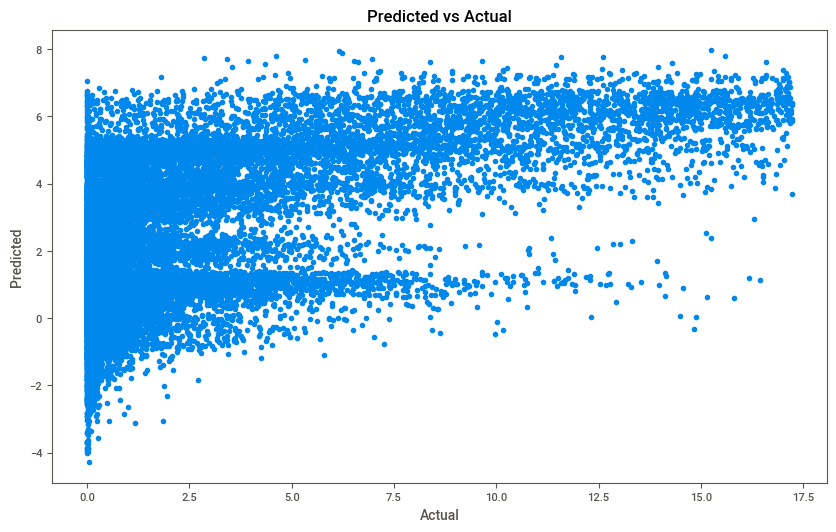

In [17]:
# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.title("Predicted vs Actual")
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
